In [1]:
# !pip install segmentation_models_pytorch

In [2]:
import torchmetrics
torchmetrics.__version__

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


'1.1.1'

In [3]:
!pip install lightning==2.0.9.post0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 853.1/853.1 kB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 90.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.31.17
    Uninstalling botocore-1.31.17:
      Successfully uninstalled botocore-1.31.17
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.5.4 requires botocore<1.31.18,>=1.31.17, but you have botocore 1.29.165 which is incompatible.


In [4]:
import os
from glob import glob 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from tqdm import tqdm
import torchmetrics
# import segmentation_models_pytorch as smp
import lightning.pytorch as pl
import torch.nn.functional as F
from torchinfo import summary
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger
import wandb
from sklearn.model_selection import train_test_split
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor, AutoImageProcessor
import timm
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [5]:
import unetformer_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.7 MB/s eta 0:00:00


In [6]:
import unetformer_loss_function_with_iou_loss as unet_loss

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.4 MB/s eta 0:00:0000:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=087fd02114ba48120efe2ed9c7c04542b5b65b5962bb9789ffd4b34da10a2f95
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=9315a9dbf4c9821dd612103f97b6dcdbde876118a1d1bd1d435693aa6ec750fb
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Attempting uninstall: timm
    Found existing instal

In [7]:
def read_txt_file(path):
    file_name_list = []
    
    with open(path, 'r') as file:
        # Read each line (filename) from the file and append it to the list
        file_name_list = [line.strip() for line in file]
        
    return file_name_list

In [8]:
train_file_names = read_txt_file("/kaggle/input/landcover-ai-patches/train.txt")[:8680]

In [9]:
len(train_file_names)

8680

In [10]:
test_file_names = read_txt_file("/kaggle/input/landcover-ai-patches/test.txt")[:1600]

In [11]:
len(test_file_names)

1600

In [12]:
val_file_names = read_txt_file("/kaggle/input/landcover-ai-patches/val.txt")[:1600]

In [13]:
len(val_file_names)

1600

# id2label

In [14]:
id2label = {
    0:"Background",
    1:"Building",
    2:"Woodland",
    3:"Water",
    4:"Road",
}

In [15]:
label2id = {v: k for k, v in id2label.items()}

In [16]:
label2id

{'Background': 0, 'Building': 1, 'Woodland': 2, 'Water': 3, 'Road': 4}

# Dataset

In [17]:
class LandCoverDataset(Dataset):
    
    def __init__(self, file_names, transform=None):
        self.img_path = '/kaggle/input/landcover-ai-patches/images/'
        self.mask_path = '/kaggle/input/landcover-ai-patches/masks/'
        self.file_names = file_names
        
        self.mean = [0.385, 0.409, 0.355]
        self.std = [0.172, 0.144, 0.123]
        
        # Albumentation Transform are used
        self.transform = transform
        
        
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        
        img = np.array(Image.open(f'{self.img_path}{self.file_names[index]}.jpg'))
        mask = cv2.imread(f'{self.mask_path}{self.file_names[index]}.png', cv2.IMREAD_GRAYSCALE)
        
        original_img = img
        original_mask = mask
        
        # Apply transform if there are transform
        if self.transform is not None:
            augmented_img_mask = self.transform(image=img, mask=mask)
            img = augmented_img_mask['image']
            mask = augmented_img_mask['mask']
            
            
        
        mask = torch.from_numpy(mask).long()
        
        # Normalize and convert to tensor
        final_transform = A.Compose([
                A.Normalize(mean=self.mean, std=self.std),
                ToTensorV2()
            ])

        img = final_transform(image=img)
        img = img['image']
        
        return img, mask, original_img, original_mask

In [18]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Rotate(limit=(-15,15),p=0.3)
])

In [19]:
train_ds = LandCoverDataset(train_file_names, transform=train_transforms)
val_ds = LandCoverDataset(val_file_names)
test_ds = LandCoverDataset(test_file_names)

In [20]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

8680
1600
1600


# Data Loader

In [21]:
train_loader = DataLoader(train_ds, batch_size=8,num_workers=2,shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8,num_workers=2)
test_loader = DataLoader(test_ds, batch_size=8,num_workers=2)

# UNetFormer
Unetformer architecture

In [22]:
class UNetFormer_pl(pl.LightningModule):
    def __init__(self, n_classes, encoder_name, lr=1e-4):
        super().__init__()
        self.n_classes = n_classes
        self.encoder_name = encoder_name
        self.lr = lr
#         self.save_hyperparameters('n_classes','lr', 'encoder_name')
        
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=n_classes, average='macro')
        self.accuracy_class = torchmetrics.Accuracy(task="multiclass", num_classes=n_classes, average=None)
        self.precision = torchmetrics.Precision(task="multiclass", num_classes=n_classes, average='macro')
        self.precision_class = torchmetrics.Precision(task="multiclass", num_classes=n_classes, average=None)
        self.recall = torchmetrics.Recall(task="multiclass", num_classes=n_classes, average='macro')
        self.recall_class = torchmetrics.Recall(task="multiclass", num_classes=n_classes, average=None)
        self.f1 = torchmetrics.F1Score(task="multiclass", num_classes=n_classes, average='macro')
        self.f1_class = torchmetrics.F1Score(task="multiclass", num_classes=n_classes, average=None)
        self.jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=n_classes, average='macro')
        self.jaccard_class = torchmetrics.JaccardIndex(task="multiclass", num_classes=n_classes,average=None)
        self.dice = torchmetrics.Dice(num_classes=n_classes, average='macro')
        
        self.loss = unet_loss.UnetFormerLoss()
#         self.loss = unet_loss.UnetFormerIouLoss()
#         self.loss = unet_loss.UnetFormerCEIouLoss()
        
        self.save_hyperparameters('n_classes','encoder_name','lr')
        
        
        self.id2label = {
            0:"Background",
            1:"Building",
            2:"Woodland",
            3:"Water",
            4:"Road",
        }
        self.label2id = {v: k for k, v in self.id2label.items()}
        
        
        self.model = unetformer_utils.UNetFormer(
            backbone_name=self.encoder_name, 
            pretrained=True,
            num_classes=self.n_classes
        )
        

    def forward(self, x):
        logits = self.model(x)
        
        return logits
    
    def training_step(self, batch, batch_idx):
        x, y, _, _ = batch
        y_hat = self(x)[0]
        loss = self.loss(y_hat, y)
        
        y_hat_argmax = torch.argmax(torch.softmax(y_hat,dim=1),dim=1)
        
        # Torch metric
        tm_acc = self.accuracy(y_hat_argmax,y)
        tm_rec = self.recall(y_hat_argmax,y)
        tm_prec = self.precision(y_hat_argmax,y)
        tm_iou = self.jaccard(y_hat_argmax,y)
        tm_f1 = self.f1(y_hat_argmax,y)
        tm_dice = self.dice(y_hat_argmax,y)
        
        
        self.log_dict({
            "train_loss":loss,
            "train_acc":tm_acc,
            "train_iou":tm_iou,
            "train_f1":tm_f1,
            "train_precision":tm_prec,
            "train_recall":tm_rec,
            "train_dice":tm_dice,
        },prog_bar=True, on_step=True, on_epoch=True)
        
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y, _, _ = batch
        y_hat = self(x)
        
        loss = self.loss(y_hat, y)
        
        y_hat_argmax = torch.argmax(torch.softmax(y_hat,dim=1),dim=1)
        
        # Torch metric
        tm_acc = self.accuracy(y_hat_argmax,y)
        tm_acc_class = self.accuracy_class(y_hat_argmax,y)
        tm_rec = self.recall(y_hat_argmax,y)
        tm_rec_class = self.recall_class(y_hat_argmax,y)
        tm_prec = self.precision(y_hat_argmax,y)
        tm_prec_class = self.precision_class(y_hat_argmax,y)
        tm_iou = self.jaccard(y_hat_argmax,y)
        tm_iou_class = self.jaccard_class(y_hat_argmax,y) 
        tm_f1 = self.f1(y_hat_argmax,y)
        tm_f1_class = self.f1_class(y_hat_argmax,y)
        tm_dice = self.dice(y_hat_argmax,y)
        
        log_dict = {
            "val_loss":loss,
            "val_acc":tm_acc,
            "val_iou":tm_iou,
            "val_f1":tm_f1,
            "val_precision":tm_prec,
            "val_recall":tm_rec,
            "val_dice":tm_dice
        }
        
        for i, x in enumerate(tm_acc_class):
            log_dict[f'val_acc_class_{self.id2label[i]}'] = x
        
        for i, x in enumerate(tm_iou_class):
            log_dict[f'val_iou_class_{self.id2label[i]}'] = x
            
        for i, x in enumerate(tm_f1_class):
            log_dict[f'val_f1_class_{self.id2label[i]}'] = x
            
        for i, x in enumerate(tm_prec_class):
            log_dict[f'val_precision_class_{self.id2label[i]}'] = x
            
        for i, x in enumerate(tm_rec_class):
            log_dict[f'val_recall_class_{self.id2label[i]}'] = x
        
        self.log_dict(
            log_dict
        ,prog_bar=True, on_step=False, on_epoch=True)
        
    def configure_optimizers(self):
        
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [23]:
model = UNetFormer_pl(n_classes=5, encoder_name="resnet34.a1_in1k")

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [24]:
model.lr

0.0001

# Model Summary

In [25]:
summary(model)

Layer (type:depth-idx)                             Param #
UNetFormer_pl                                      --
├─MulticlassAccuracy: 1-1                          --
├─MulticlassAccuracy: 1-2                          --
├─MulticlassPrecision: 1-3                         --
├─MulticlassPrecision: 1-4                         --
├─MulticlassRecall: 1-5                            --
├─MulticlassRecall: 1-6                            --
├─MulticlassF1Score: 1-7                           --
├─MulticlassF1Score: 1-8                           --
├─MulticlassJaccardIndex: 1-9                      --
├─MulticlassJaccardIndex: 1-10                     --
├─Dice: 1-11                                       --
├─UnetFormerLoss: 1-12                             --
│    └─JointLoss: 2-1                              --
│    │    └─WeightedLoss: 3-1                      --
│    │    └─WeightedLoss: 3-2                      --
│    └─SoftCrossEntropyLoss: 2-2                   --
├─UNetFormer: 1-13     

# LR Finder

In [26]:
# lr_trainer = pl.Trainer()
# tuner = pl.tuner.Tuner(lr_trainer)

In [27]:
# lr_finder = tuner.lr_find(
#     model, 
#     train_dataloaders=train_loader,
# )

In [28]:
# fig = lr_finder.plot(suggest=True)
# fig.show()

In [29]:
model.lr

0.0001

In [30]:
model.lr = 5e-4

In [31]:
model.lr

0.0005

# Logger

In [32]:
wandb_logger = WandbLogger(name="unetformer_landcoverai_resnet34_ce_dice_v1",project="skripsi_landcoverai_augment")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [33]:
wandb.run.id

'52am41qf'

# Callbacks

In [34]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    filename='unetformer_landcoverai_resnet34_ce_dice_v1'
)

In [35]:
trainer = pl.Trainer(
    fast_dev_run=False,
    max_epochs=10,
    callbacks=[EarlyStopping(monitor="val_loss",patience=5),checkpoint_callback],
    logger=wandb_logger,
    log_every_n_steps=10
)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


# Training

In [36]:
trainer.fit(model,train_loader,val_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name            | Type                   | Params
------------------------------------------------------------
0  | accuracy        | MulticlassAccuracy     | 0     
1  | accuracy_class  | MulticlassAccuracy     | 0     
2  | precision       | MulticlassPrecision    | 0     
3  | precision_class | MulticlassPrecision    | 0     
4  | recall          | MulticlassRecall       | 0     
5  | recall_class    | MulticlassRecall       | 0     
6  | f1              | MulticlassF1Score      | 0     
7  | f1_class        | MulticlassF1Score      | 0     
8  | jaccard         | MulticlassJaccardIndex | 0     
9  | jaccard_class   | MulticlassJaccardIndex | 0     
10 | dice            | Dice                   | 0     
11 | loss            | UnetFormerLoss         | 0     
12 | model           | UNetFormer             | 21.8 M
------------------------------------------------------------
21.8 M    Trainable params
0         Non-trainable pa

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.


# Validate

In [37]:
trainer.validate(model,val_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Validate metric         ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            val_acc             │       0.7794423699378967       │
│    val_acc_class_Background    │       0.9414428472518921       │
│     val_acc_class_Building     │       0.4336923360824585       │
│       val_acc_class_Road       │       0.5771864056587219       │
│      val_acc_class_Water       │       0.5120099782943726       │
│     val_acc_class_Woodland     │       0.8488491177558899       │
│            val_dice            │       0.7839204668998718       │
│             val_f1             │       0.7839204668998718       │
│    val_f1_class_Background     │       0.9376482367515564       │
│     val_f1_class_Building      │       0.4308638274669647       │
│       val_f1_class_Road        │        0.6286581158638         │
│       val_f1_class_Water       │      0.47636520862579346       │
│     val_f1_class_Woodland      │       0.8581992983818054       │
│            val_iou             │       0.7072328329086304       │
│    val_iou_class_Background    │        0.88869309425354        │
│     val_iou_class_Building     │      0.38217398524284363       │
│       val_iou_class_Road       │       0.5129321813583374       │
│      val_iou_class_Water       │       0.4372062385082245       │
│     val_iou_class_Woodland     │       0.7811545729637146       │
│            val_loss            │       0.5779213905334473       │
│         val_precision          │       0.8165920376777649       │
│ val_precision_class_Background │       0.9372656941413879       │
│  val_precision_class_Building  │       0.4336671531200409       │
│    val_precision_class_Road    │       0.7524860501289368       │
│   val_precision_class_Water    │      0.46424615383148193       │
│  val_precision_class_Woodland  │       0.8816741704940796       │
│           val_recall           │       0.7794423699378967       │
│  val_recall_class_Background   │       0.9414428472518921       │
│   val_recall_class_Building    │       0.4336923360824585       │
│     val_recall_class_Road      │       0.5771864056587219       │
│     val_recall_class_Water     │       0.5120099782943726       │
│   val_recall_class_Woodland    │       0.8488491177558899       │
└────────────────────────────────┴────────────────────────────────┘

[{'val_loss': 0.5779213905334473,
  'val_acc': 0.7794423699378967,
  'val_iou': 0.7072328329086304,
  'val_f1': 0.7839204668998718,
  'val_precision': 0.8165920376777649,
  'val_recall': 0.7794423699378967,
  'val_dice': 0.7839204668998718,
  'val_acc_class_Background': 0.9414428472518921,
  'val_acc_class_Building': 0.4336923360824585,
  'val_acc_class_Woodland': 0.8488491177558899,
  'val_acc_class_Water': 0.5120099782943726,
  'val_acc_class_Road': 0.5771864056587219,
  'val_iou_class_Background': 0.88869309425354,
  'val_iou_class_Building': 0.38217398524284363,
  'val_iou_class_Woodland': 0.7811545729637146,
  'val_iou_class_Water': 0.4372062385082245,
  'val_iou_class_Road': 0.5129321813583374,
  'val_f1_class_Background': 0.9376482367515564,
  'val_f1_class_Building': 0.4308638274669647,
  'val_f1_class_Woodland': 0.8581992983818054,
  'val_f1_class_Water': 0.47636520862579346,
  'val_f1_class_Road': 0.6286581158638,
  'val_precision_class_Background': 0.9372656941413879,
  'val

In [38]:
trainer.validate(model,test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Validate metric         ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            val_acc             │       0.7622058987617493       │
│    val_acc_class_Background    │       0.9181052446365356       │
│     val_acc_class_Building     │      0.43577414751052856       │
│       val_acc_class_Road       │       0.5492153763771057       │
│      val_acc_class_Water       │       0.5085975527763367       │
│     val_acc_class_Woodland     │       0.8567840456962585       │
│            val_dice            │       0.7705982327461243       │
│             val_f1             │       0.770598292350769        │
│    val_f1_class_Background     │       0.9156435132026672       │
│     val_f1_class_Building      │       0.4332570731639862       │
│       val_f1_class_Road        │       0.6040322184562683       │
│       val_f1_class_Water       │       0.4817853569984436       │
│     val_f1_class_Woodland      │       0.8689447641372681       │
│            val_iou             │       0.6938964128494263       │
│    val_iou_class_Background    │       0.8625108599662781       │
│     val_iou_class_Building     │      0.38043487071990967       │
│       val_iou_class_Road       │       0.4923870861530304       │
│      val_iou_class_Water       │       0.439034104347229        │
│     val_iou_class_Woodland     │       0.7958954572677612       │
│            val_loss            │       0.596570611000061        │
│         val_precision          │       0.8200419545173645       │
│ val_precision_class_Background │       0.921395480632782        │
│  val_precision_class_Building  │       0.4388050138950348       │
│    val_precision_class_Road    │       0.7647899389266968       │
│   val_precision_class_Water    │       0.4904899597167969       │
│  val_precision_class_Woodland  │       0.8970974683761597       │
│           val_recall           │       0.7622058987617493       │
│  val_recall_class_Background   │       0.9181052446365356       │
│   val_recall_class_Building    │      0.43577414751052856       │
│     val_recall_class_Road      │       0.5492153763771057       │
│     val_recall_class_Water     │       0.5085975527763367       │
│   val_recall_class_Woodland    │       0.8567840456962585       │
└────────────────────────────────┴────────────────────────────────┘

[{'val_loss': 0.596570611000061,
  'val_acc': 0.7622058987617493,
  'val_iou': 0.6938964128494263,
  'val_f1': 0.770598292350769,
  'val_precision': 0.8200419545173645,
  'val_recall': 0.7622058987617493,
  'val_dice': 0.7705982327461243,
  'val_acc_class_Background': 0.9181052446365356,
  'val_acc_class_Building': 0.43577414751052856,
  'val_acc_class_Woodland': 0.8567840456962585,
  'val_acc_class_Water': 0.5085975527763367,
  'val_acc_class_Road': 0.5492153763771057,
  'val_iou_class_Background': 0.8625108599662781,
  'val_iou_class_Building': 0.38043487071990967,
  'val_iou_class_Woodland': 0.7958954572677612,
  'val_iou_class_Water': 0.439034104347229,
  'val_iou_class_Road': 0.4923870861530304,
  'val_f1_class_Background': 0.9156435132026672,
  'val_f1_class_Building': 0.4332570731639862,
  'val_f1_class_Woodland': 0.8689447641372681,
  'val_f1_class_Water': 0.4817853569984436,
  'val_f1_class_Road': 0.6040322184562683,
  'val_precision_class_Background': 0.921395480632782,
  'va

# Save

In [39]:
trainer.save_checkpoint("unetformer_landcoverai_resnet34_ce_dice_0_10_v1_checkpoint.ckpt")

In [40]:
torch.save(model, "unetformer_landcoverai_resnet34_ce_dice_0_10_v1.pth")

In [41]:
torch.save(model.state_dict(), "unetformer_landcoverai_resnet34_ce_dice_0_10_v1_state_dict.pth")

In [42]:
wandb.save('/kaggle/working/unetformer_landcoverai_resnet34_ce_dice_0_10_v1.pth')

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


['./wandb/run-20231211_065044-52am41qf/files/unetformer_landcoverai_resnet34_ce_dice_0_10_v1.pth']

In [43]:
wandb.save('/kaggle/working/unetformer_landcoverai_resnet34_ce_dice_0_10_v1_state_dict.pth')

['./wandb/run-20231211_065044-52am41qf/files/unetformer_landcoverai_resnet34_ce_dice_0_10_v1_state_dict.pth']

In [44]:
wandb.save('/kaggle/working/unetformer_landcoverai_resnet34_ce_dice_0_10_v1_checkpoint.ckpt')

['./wandb/run-20231211_065044-52am41qf/files/unetformer_landcoverai_resnet34_ce_dice_0_10_v1_checkpoint.ckpt']

In [45]:
wandb.save(checkpoint_callback.best_model_path)

['./wandb/run-20231211_065044-52am41qf/files/skripsi_landcoverai_augment/52am41qf/checkpoints/unetformer_landcoverai_resnet34_ce_dice_v1.ckpt']

In [46]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_acc_epoch,▁▄▆▆▇▇████
train_acc_step,▆▁▅▇▅▄▆▅▇▆▆▅▇▂▇▇▅▇▃▇▆▄▇▇██▆███▇▇█▄▇▇▆▅▇▇
train_dice_epoch,▁▄▆▇▇▇████
train_dice_step,▆▁▅▇▄▅▆▅▇▆▇▅▇▃██▆█▄█▇▅▇▆██▆██▇▇▇█▄█▇▇▆██
train_f1_epoch,▁▄▆▇▇▇████
train_f1_step,▆▁▅▇▄▅▆▅▇▆▇▅▇▃██▆█▄█▇▅▇▆██▆██▇▇▇█▄█▇▇▆██
train_iou_epoch,▁▄▆▆▇▇▇▇██
train_iou_step,▆▁▅▇▃▄▆▅▇▅▇▅▇▃▇▇▅█▄▇▆▅▆▅██▆▇█▇▆▇█▄▇▇▇▆▇▇
train_loss_epoch,█▄▃▂▂▂▂▂▁▁
train_loss_step,▄█▅▃▇▄▄▆▃▄▃▂▂▃▂▃▃▁▃▂▃▃▄▄▂▁▂▂▁▃▃▂▂▅▂▂▂▁▃▂


# Inference

In [47]:
def unetformer_inference(model, im_t):
    """
    model: UNetFormer_pl
    im_t: image as tensor -> [5,512,512]
    """
    model.eval()
    out = model(im_t.unsqueeze(0))
    pred = torch.argmax(torch.softmax(out, dim=1), dim=1)
    
    
    return pred.squeeze(0)

In [48]:
im_t, ma_t, ori_im, ori_ma = test_ds[389]

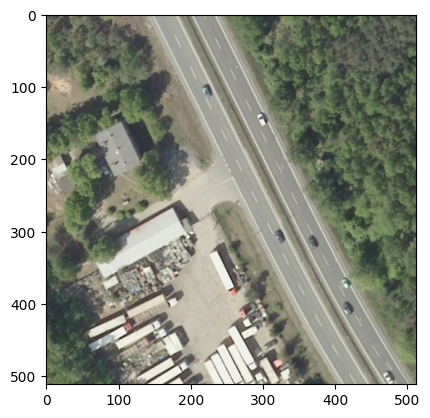

In [49]:
plt.imshow(ori_im)

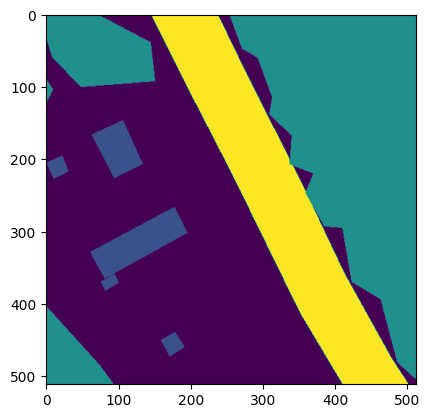

In [50]:
plt.imshow(ori_ma)

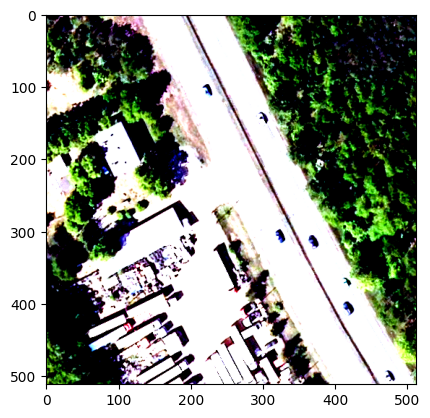

In [51]:
plt.imshow(im_t.permute(1,2,0))

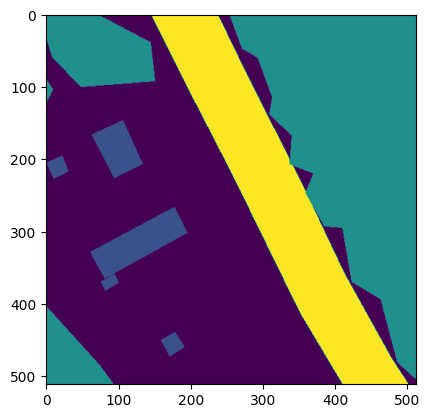

In [52]:
plt.imshow(ma_t)

In [53]:
pred = unetformer_inference(model,im_t)

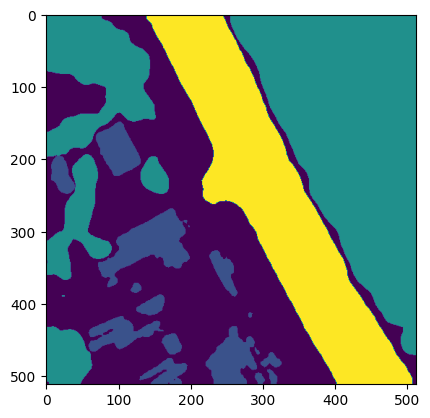

In [54]:
plt.imshow(pred)

In [55]:
im_1, ma_1, ori_im_1, ori_ma_1 = test_ds[500]

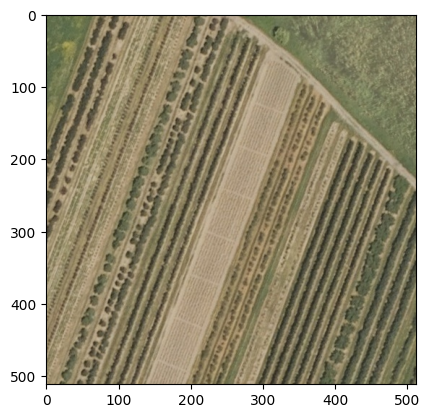

In [56]:
plt.imshow(ori_im_1)

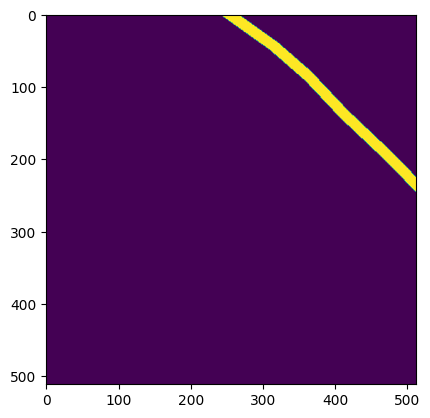

In [57]:
plt.imshow(ori_ma_1)

In [58]:
pred1 = unetformer_inference(model,im_1)

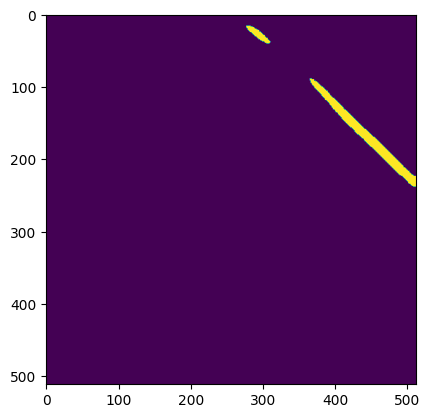

In [59]:
plt.imshow(pred1)

In [60]:
im_2, ma_2, ori_im_2, ori_ma_2 = test_ds[123]

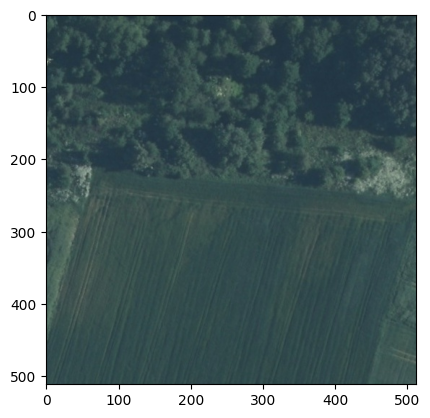

In [61]:
plt.imshow(ori_im_2)

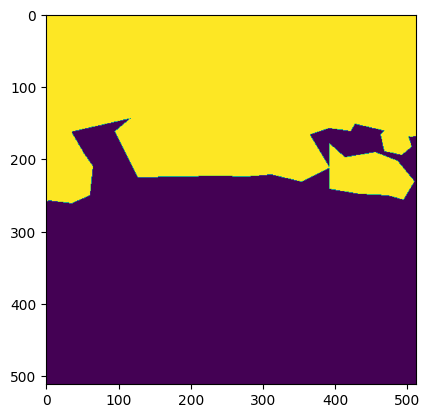

In [62]:
plt.imshow(ori_ma_2)

In [63]:
pred2 = unetformer_inference(model,im_2)

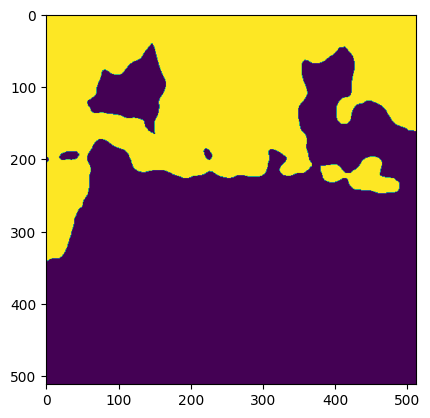

In [64]:
plt.imshow(pred2)